# Introduction

This project focuses on predicting diabetes using patient medical records from the Kaggle Diabetes Health Indicators dataset. Diabetes is a chronic condition where early detection is crucial. However, class imbalance in medical datasets can make prediction difficult — especially when false negatives (Type II errors) are dangerous.  

To address this, we built a robust Stacking Ensemble model using Logistic Regression, Random Forest, Gradient Boosting, and XGBoost, with a final logistic meta-learner. We applied class-weight adjustments and decision threshold optimization to minimize false negatives and improve recall for diabetic patients. The model was evaluated using F1-score, ROC-AUC, and SHAP values for interpretability.


# Loading Libraries and Dataset

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold,RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report,confusion_matrix,roc_curve, roc_auc_score, f1_score, precision_recall_curve

import os 
import shap 
import joblib 
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
np.random.seed(42)

In [3]:
file_path=r'/kaggle/input/diabetes-prediction-dataset/diabetes_prediction_dataset.csv'
if not os.path.exists(file_path):
    raise FileNotFoundError (f"Datasets not found at {file_path}\n Please check the path of the file")

data=pd.read_csv(file_path)

In [4]:
data.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


# Explotary Data Analysis

In [5]:
print('Data Shape: ',data.shape)
print('\nData Info:')
print(data.info())

numeric_columns=[col for col in data.select_dtypes(exclude='object').columns if col!='diabetes' ]
categorical_column=data.select_dtypes(include='object').columns.tolist()
target_column='diabetes'

print(f'Unique Values in {categorical_column}:')
for col in categorical_column:
    print(data[col].value_counts())

Data Shape:  (100000, 9)

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB
None
Unique Values in ['gender', 'smoking_history']:
gender
Female    58552
Male      41430
Other        18
Name: count, dtype: int64
smoking_history
No Info        35816
never          35095
former          9352
current         92

In [6]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
age,100000.0,41.885856,22.516840,0.08,24.00,43.00,60.00,80.00
hypertension,100000.0,0.074850,0.263150,0.00,0.00,0.00,0.00,1.00
heart_disease,100000.0,0.039420,0.194593,0.00,0.00,0.00,0.00,1.00
bmi,100000.0,27.320767,6.636783,10.01,23.63,27.32,29.58,95.69
HbA1c_level,100000.0,5.527507,1.070672,3.50,4.80,5.80,6.20,9.00
blood_glucose_level,100000.0,138.058060,40.708136,80.00,100.00,140.00,159.00,300.00
diabetes,100000.0,0.085000,0.278883,0.00,0.00,0.00,0.00,1.00


diabetes
0    91500
1     8500
Name: count, dtype: int64

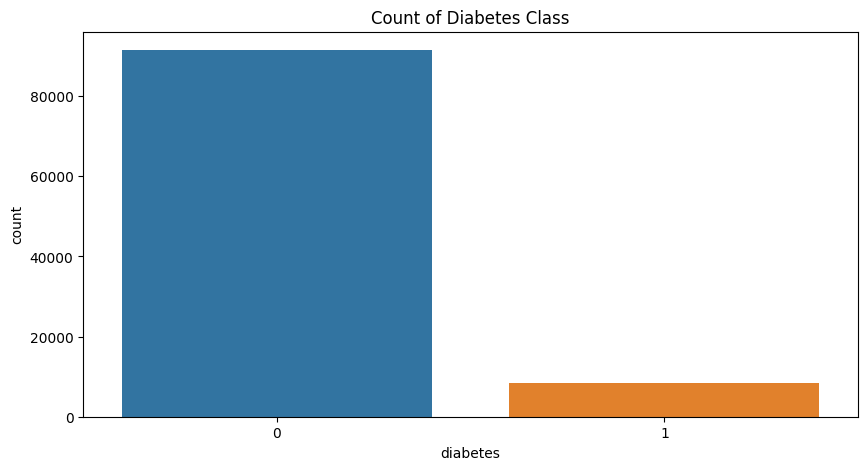

In [7]:
plt.figure(figsize=(10,5))
sns.countplot(x=target_column,data=data)
plt.title('Count of Diabetes Class')

data[target_column].value_counts()

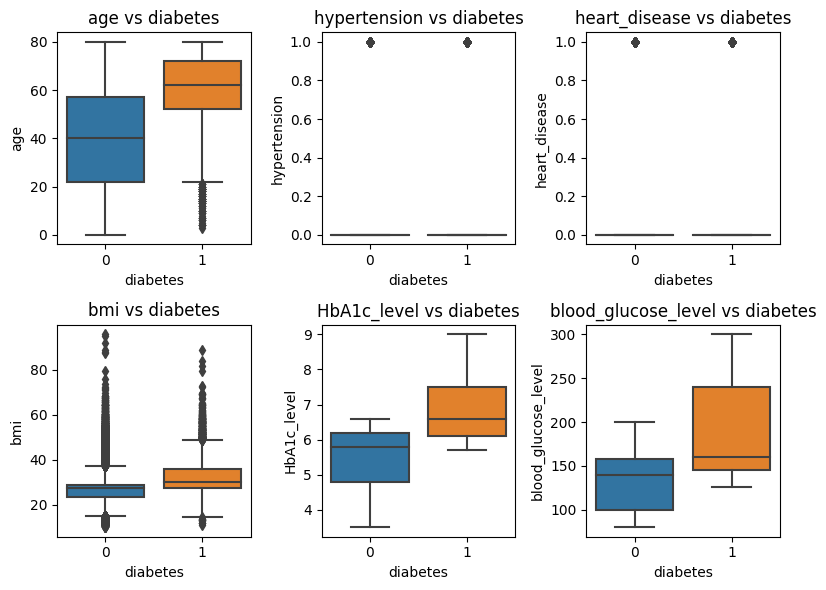

In [8]:
plt.figure(figsize=(8,6))
for i,col in enumerate(numeric_columns,1):
    plt.subplot(2,3,i)
    sns.boxplot(x=target_column, y=col, data=data)
    plt.title(f'{col} vs diabetes')
plt.tight_layout()
plt.show()

# Data Preprocessing

In [9]:
#removing Other rows from data which has no significant impact to data
data=data[data['gender']!='Other']

data=pd.get_dummies(data,columns=categorical_column, drop_first=True)

data.shape

(99982, 13)

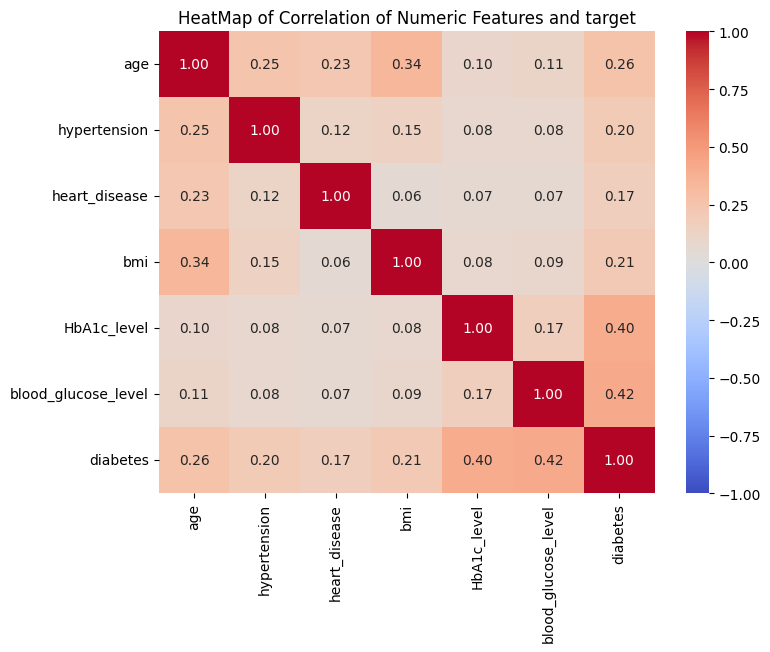

In [10]:
plt.figure(figsize=(8,6))
sns.heatmap(data[numeric_columns+[target_column]].corr(),annot=True,cmap='coolwarm',fmt='.2f',vmin=-1,vmax=1)
plt.title('HeatMap of Correlation of Numeric Features and target')
plt.show()

In [11]:
x=data.drop(target_column,axis=1)
y=data[target_column]

In [12]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.1,stratify=y,random_state=42)

In [13]:
# Clip outliers using IQR
def clip_outliers_iqr(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        df[col] = df[col].clip(lower=lower, upper=upper)
    return df

# Apply to train and test
x_train = clip_outliers_iqr(x_train, numeric_columns)
x_test = clip_outliers_iqr(x_test, numeric_columns)

In [14]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [15]:
x_train.head()

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,gender_Male,smoking_history_current,smoking_history_ever,smoking_history_former,smoking_history_never,smoking_history_not current
29105,60.0,0,0,21.28,6.5,130.0,False,False,False,False,False,False
85968,48.0,0,0,33.19,5.8,140.0,False,False,False,False,True,False
49436,30.0,0,0,21.63,6.0,158.0,False,False,False,False,False,False
90869,9.0,0,0,15.26,5.7,90.0,True,False,False,False,False,False
1123,39.0,0,0,21.06,4.5,100.0,False,False,False,False,True,False


# Model Training and Evaluation

In [16]:
from catboost import CatBoostClassifier

# Add CatBoost to default models
default_models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss'),
    'CatBoost': CatBoostClassifier(verbose=0, random_state=42)
}

# Store results
default_results = []

for name, model in default_models.items():
    x_train_current = x_train_scaled if name in ['Logistic Regression'] else x_train
    x_test_current = x_test_scaled if name in ['Logistic Regression'] else x_test

    model.fit(x_train_current, y_train)
    y_pred = model.predict(x_test_current)
    f1 = f1_score(y_test, y_pred, average='weighted')
    default_results.append({'Model': name, 'F1_weighted': f1})

# Create DataFrame
default_df = pd.DataFrame(default_results).sort_values(by='F1_weighted', ascending=False)

# Display
default_df

,Model,F1_weighted
2,Gradient Boosting,0.970406
4,XGBoost,0.969641
5,CatBoost,0.968308
1,Random Forest,0.967679
0,Logistic Regression,0.956397
3,Decision Tree,0.950667


In [17]:
# Gradient Boosting hyperparameter grid
gb_params = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.03, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'max_features': ['sqrt', 'log2', None]
}

gb_model = GradientBoostingClassifier(random_state=42)

# RandomizedSearchCV
gb_clf = RandomizedSearchCV(
    gb_model,
    gb_params,
    n_iter=20,
    cv=3,
    scoring='f1_weighted',
    n_jobs=-1,
    random_state=42
)

# Fit
gb_clf.fit(x_train, y_train)

# Results
print('model:', 'Gradient Boosting')
print('best_score:', gb_clf.best_score_)
print('best_params:', gb_clf.best_params_)


model: Gradient Boosting
best_score: 0.9692926292447194
best_params: {'n_estimators': 200, 'max_features': 'log2', 'max_depth': 7, 'learning_rate': 0.03}


In [18]:
from sklearn.pipeline import make_pipeline

# Base models (with scaling)
base_learners = [
    ('lr', make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000,class_weight='balanced'))),
    ('xgb', XGBClassifier(random_state=42, eval_metric='logloss',scale_pos_weight=(y_train == 0).sum()/ (y_train == 1).sum())),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42,class_weight='balanced')),
    ('gb', GradientBoostingClassifier(**gb_clf.best_params_, random_state=42))
]

# Meta-learner (final estimator)
meta_model = LogisticRegression(max_iter=1000,class_weight='balanced')

# StackingClassifier
stacking_clf = StackingClassifier(
    estimators=base_learners,
    final_estimator=meta_model,
    cv=5,
    n_jobs=-1,
    passthrough=False
)

# Fit model
stacking_clf.fit(x_train, y_train)

# Predict
y_pred = stacking_clf.predict(x_test)

# Evaluation
print("F1-weighted score:", f1_score(y_test, y_pred, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


F1-weighted score: 0.9265850219080829

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.92      0.95      9149
           1       0.51      0.89      0.64       850

    accuracy                           0.92      9999
   macro avg       0.75      0.90      0.80      9999
weighted avg       0.95      0.92      0.93      9999



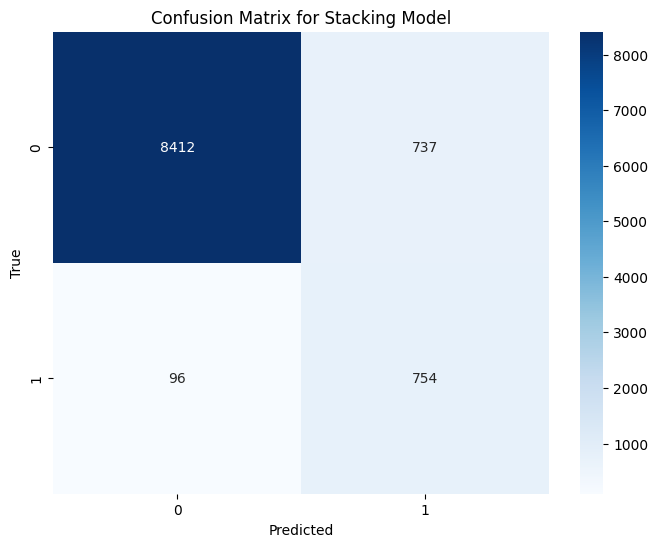

In [19]:
# Confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for Stacking Model')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('/kaggle/working/confusion_matrix_plot.png')
plt.show()

Chosen threshold = 0.112, Recall = 0.979, Precision = 0.300

Balanced Classification Report:
              precision    recall  f1-score   support

          no       1.00      0.79      0.88      9149
         yes       0.30      0.98      0.46       850

    accuracy                           0.80      9999
   macro avg       0.65      0.88      0.67      9999
weighted avg       0.94      0.80      0.84      9999


⚠️ Final Threshold Chosen: 0.112
🔍 Objective: High Recall (≥ 0.90), Acceptable Precision (≥ 0.30)


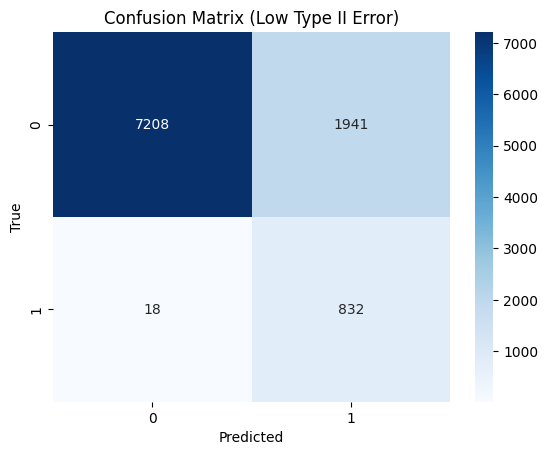

In [38]:
# Get predicted probabilities
y_scores = stacking_clf.predict_proba(x_test)[:, 1]

# Precision-Recall Curve
prec, rec, thresh = precision_recall_curve(y_test, y_scores)

best_idx = -1
for i in range(len(thresh)):
    if rec[i] >= 0.90 and prec[i] >= 0.30:
        best_idx = i
        break

if best_idx != -1:
    best_thresh = thresh[best_idx]
    print(f"Chosen threshold = {best_thresh:.3f}, Recall = {rec[best_idx]:.3f}, Precision = {prec[best_idx]:.3f}")
    
    y_pred_balanced = (y_scores >= best_thresh).astype(int)
    print("\nBalanced Classification Report:")
    print(classification_report(y_test, y_pred_balanced, target_names=['no','yes']))
else:
    print("No threshold found that meets both precision ≥ 0.30 and recall ≥ 0.90")

print(f"\n⚠️ Final Threshold Chosen: {best_thresh:.3f}")
print(f"🔍 Objective: High Recall (≥ 0.90), Acceptable Precision (≥ 0.30)")

# Confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(y_test, y_pred_balanced)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (Low Type II Error)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.savefig('/kaggle/working/confusion_matrix_plot.png')
plt.show()

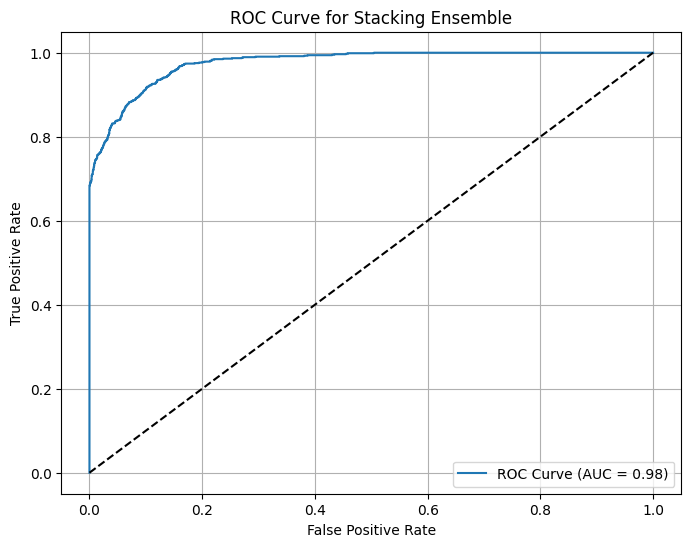

In [33]:
y_scores = stacking_clf.predict_proba(x_test)[:, 1]

# ROC Curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = roc_auc_score(y_test, y_scores)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Stacking Ensemble')
plt.legend(loc='lower right')
plt.grid(True)
plt.savefig('/kaggle/working/roc_curve.png')
plt.show()

# Feature Importance and Interpretability

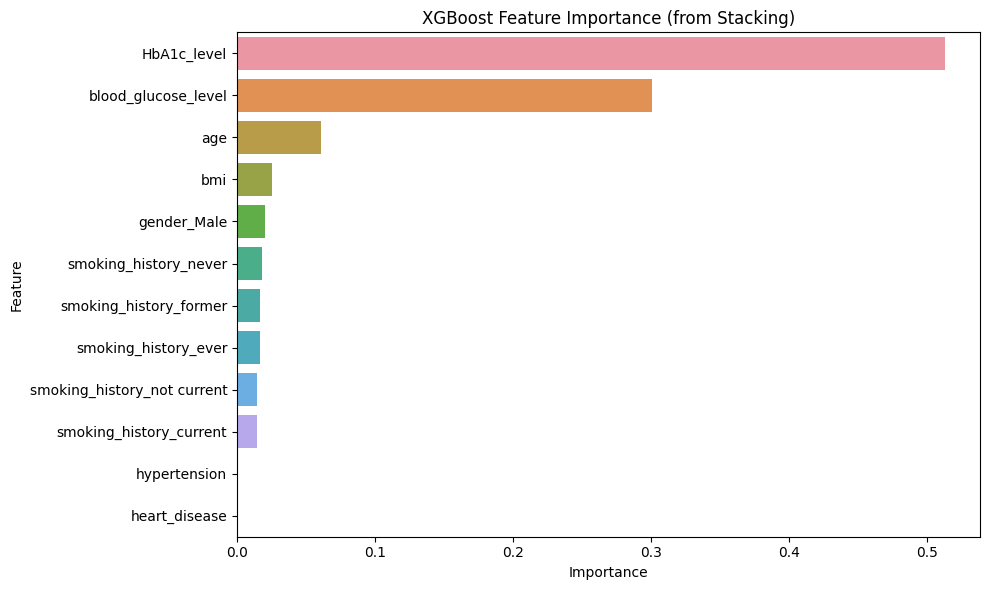

In [34]:
# Get trained XGBoost model from the stack
xgb_model = stacking_clf.named_estimators_['xgb']

# Create feature importance DataFrame
feature_importance = pd.DataFrame({
    'Feature': x_train.columns,
    'Importance': xgb_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Save to CSV
feature_importance.to_csv('/kaggle/working/feature_importance.csv', index=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('XGBoost Feature Importance (from Stacking)')
plt.tight_layout()
plt.savefig('/kaggle/working/feature_importance_plot.png')
plt.show()

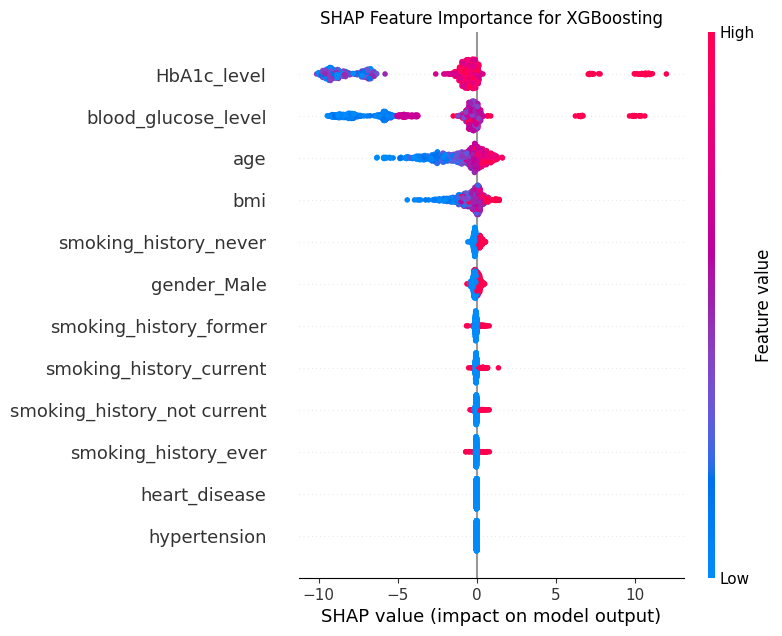

In [35]:
# SHAP values (using a sample for efficiency)
x_test_sample = x_test.sample(frac=0.1, random_state=42)
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(x_test_sample)
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, x_test_sample, feature_names=x_test.columns, show=False)
plt.title('SHAP Feature Importance for XGBoosting')
plt.savefig('/kaggle/working/shap_summary.png')
plt.show()

# Conclusion

Our final Stacking model achieved a strong balance between precision and recall, with a recall of 97.9% for diabetic cases using a tuned threshold. SHAP analysis showed that HbA1c level and blood glucose level were the most influential features in the model's predictions — aligning with clinical understanding.  

This workflow demonstrates how ensemble learning, class imbalance handling, threshold tuning, and model interpretability can work together to build a practical, medically sensitive classifier. The model is saved using `joblib` and can be deployed for real-time inference in healthcare screening systems.


In [36]:
# Save the stacking model to disk
joblib.dump(stacking_clf, '/kaggle/working/stacking_model.joblib')

['/kaggle/working/stacking_model.joblib']